# PPI-V

Neste documento, avaliaremos o desempenho do padrão apresentado no seguinte vídeo:
- https://www.youtube.com/watch?v=4PlSmIERBgY&ab_channel=RaioXPreditivohttps://www.youtube.com/watch?v=4PlSmIERBgY&ab_channel=RaioXPreditivo


In [25]:
import pandas as pd
import datetime
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from scipy.signal import argrelextrema

df = pq.ParquetFile("win_1min.parquet").read().to_pandas()
# df = pq.ParquetFile("/Volumes/b3_market_data/candle_data/bmf/win_1min.parquet").read().to_pandas()

In [26]:
df

,open,high,low,close,tick_volume,spread,real_volume
index,,,,,,,
2016-09-06 09:00:00,60500.0,60570.0,60500.0,60560.0,199,5,896
2016-09-06 09:01:00,60540.0,60640.0,60505.0,60540.0,544,5,1705
2016-09-06 09:02:00,60530.0,60550.0,60485.0,60490.0,277,5,758
2016-09-06 09:03:00,60485.0,60505.0,60330.0,60425.0,809,5,2444
2016-09-06 09:04:00,60425.0,60480.0,60420.0,60465.0,282,5,641
...,...,...,...,...,...,...,...
2021-09-21 17:51:00,110310.0,110365.0,110290.0,110355.0,670,0,4861
2021-09-21 17:52:00,110350.0,110365.0,110295.0,110305.0,621,0,5235
2021-09-21 17:53:00,110305.0,110325.0,110230.0,110280.0,747,0,4641


In [142]:
# dt1 = datetime.datetime(2020, 5, 3, 9, 52)
# dt2 = datetime.datetime(2020, 5, 5, 10, 15)
# df_ = df_[(df_.index >= dt1) & (df_.index <= dt2)].copy()

In [27]:
minimo_local_range = 5

df_ = df.copy()

# Script para localizar mínimos locais no gráfico
df_["i"] = np.arange(len(df_))

local_min_idx=argrelextrema(df_.low.values, np.less, order=minimo_local_range, mode="wrap")[0]
local_max_idx=argrelextrema(df_.high.values, np.greater, order=minimo_local_range, mode="wrap")[0]
local_min_idx=np.array(local_min_idx)
local_max_idx=np.array(local_max_idx)

local_min=[]
local_max=[]
for loc in local_min_idx:
  local_min.append(df_.low[loc])
for loc in local_max_idx:
  local_max.append(df_.high[loc])
local_min=np.array(local_min)
local_max=np.array(local_max)

df_["local_min"] = 0
df_["local_max"] = 0
df_.loc[df_["i"].isin(local_min_idx), "local_min"] = 1
df_.loc[df_["i"].isin(local_max_idx), "local_max"] = 1

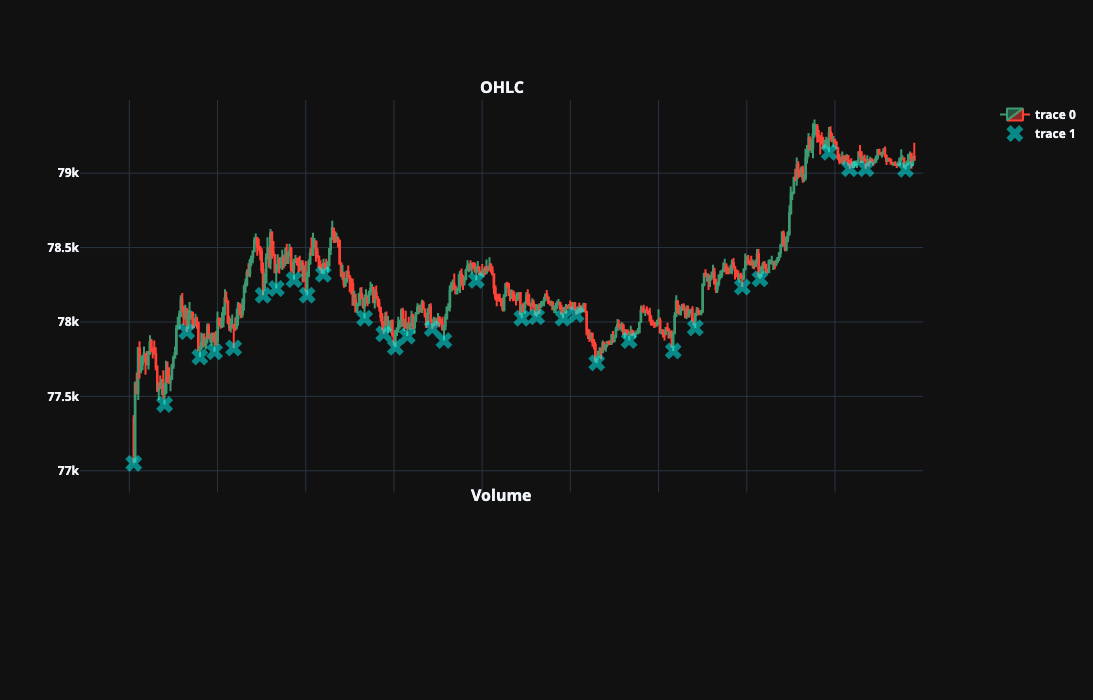

In [29]:
# Visualiza as mínimas locais em determinado dia, apenas para fins de checagem
dt1 = datetime.datetime(2020, 5, 3, 9, 52)
dt2 = datetime.datetime(2020, 5, 4, 18, 15)
df_2 = df_[(df_.index >= dt1) & (df_.index <= dt2)].copy()

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, specs=[[{"secondary_y": False}], [{"secondary_y": True}]],
                    vertical_spacing=0.03, subplot_titles=('OHLC', 'Volume'), row_width=[0.2, 0.7])

fig.add_trace(go.Candlestick(x=df_2.index, open=df_2['open'], high=df_2['high'], low=df_2['low'], close=df_2['close']), row=1, col=1)
fig.add_trace(go.Scatter(x=df_2[df_2["local_min"] == 1].index, y=df_2[df_2["local_min"] == 1]["low"], mode="markers", marker_color="cyan", marker_symbol="x", marker_size=15, opacity=0.5), row=1, col=1)

fig.update_layout(template="plotly_dark", xaxis_rangeslider_visible=False, height=700)
fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"]), dict(bounds=[18, 9], pattern="hour")])

fig.show()

## Encontrando pontos onde as seguintes condições são verificadas:
1. O ponto é uma mínima local.
2. Um padrão de queda é verificado em 3 sucessivas avaliações anteriores à mínima.
3. Um padrão de alta é verificado em 3 sucessivas avaliações posteriores à mínima.
4. O ponto é o mínimo em um intervalo de "n" janelas temporais
5. Há um grande volume sendo negociado nos 3 últimos candles ao redor.

In [31]:
# Parâmetros

window_stoch = 25
step_v = 2
vol_window_size = 100

In [32]:
# Cálculo de variáveis usadas para estimar níveis de volume
df_["roll_vol"] = df_["real_volume"].rolling(window=3).sum()
df_["roll_vol_mean"] = df_["roll_vol"].rolling(window=vol_window_size).mean()
df_["roll_vol_std"] = df_["roll_vol_mean"].rolling(window=vol_window_size).std()


# Lógica para garantir que a mínima escolhida pelo padrão seja a mínima nos últimos "n" minutos
df_["last_min_price"] = np.nan
df_.loc[df_["local_min"] == 1, "last_min_price"] = df_.loc[df_["local_min"] == 1, "low"]
df_["last_min_price"] = df_["last_min_price"].ffill()

df_["rol_min"] = df_["low"].rolling(window=vol_window_size).min()
df_["s_rol_min"] = df_["low"].rolling(window=window_stoch).min()
df_["s_rol_max"] = df_["high"].rolling(window=window_stoch).max()
df_["stoch"] = (df_["close"] - df_["s_rol_min"]) / (df_["s_rol_max"] - df_["s_rol_min"])
df_["candle_side"] = np.sign(df_["close"] - df_["open"])

In [33]:
ppvi_bool = df_["local_min"] == 1

# Verificações de quedas em 3 avaliações sucessivas anteriores à mínima
up_d1 = (df_["close"] < df_["close"].shift(step_v)) & (df_["close"].shift(step_v) < df_["close"].shift(step_v * 2)) & (df_["close"].shift(2 * step_v) < df_["close"].shift(step_v * 3))
up_d2 = (df_["close"] < df_["close"].shift(step_v-1)) & (df_["close"].shift(step_v-1) < df_["close"].shift(step_v * 2 - 1)) & (df_["close"].shift(2 * step_v - 1) < df_["close"].shift(step_v * 3 - 1))
ppvi_bool = (up_d1 | up_d2) & (ppvi_bool)

# Verificações de altas em 3 avaliações sucessivas posteriores à mínima
up_p1 = (df_["close"] < df_["close"].shift(-step_v)) & (df_["close"].shift(-step_v) < df_["close"].shift(-step_v * 2)) & (df_["close"].shift(-2*step_v) < df_["close"].shift(-step_v * 3))
up_p2 = (df_["close"] < df_["close"].shift(-step_v+1)) & (df_["close"].shift(-step_v+1) < df_["close"].shift(-step_v * 2 + 1)) & (df_["close"].shift(-2*step_v + 1) < df_["close"].shift(-step_v * 3 + 1))
ppvi_bool = (up_p1 | up_p2) & (ppvi_bool)

# O ponto é a mínima dentro de uma janela de "vol_window_size"
ppvi_bool = (df_["rol_min"] == df_["last_min_price"]) & (ppvi_bool)

# O Volume negociado está acima da média
ppvi_bool = (df_["roll_vol"] > df_["roll_vol_mean"] + 2 * df_["roll_vol_std"]) & (ppvi_bool)

df_["v_pattern"] = 0
df_.loc[ppvi_bool, "v_pattern"] = 1

## Encontrando pontos posteriores ao padrão V que cumprirem as seguintes condições:
1. Há algum padrão de V, filtrado pelas características anteriores em "window_stoch" - a janela mínima de aferiçã do padrão
2. O estocástico deste ponto está entre 0.1 e 0.3.
3. O Candle deve ser de baixa, para "testar" a região apresentada no vídeo.

In [41]:
# Deve haver algum padrão V entre "window_stoch" janelas temporais e "step_v"
df_["v_pattern_near"] = df_["v_pattern"].rolling(window=window_stoch).sum() - df_["v_pattern"].rolling(window=step_v*3 + 1).sum()
df_["ppvi"] = (df_["v_pattern_near"] >= 1) & (df_["stoch"] > 0.1) & (df_["stoch"] < 0.3) & (df_["close"] > df_["last_min_price"]) & (df_["candle_side"] == -1)

df_["rolling_ppvi"] = df_["ppvi"].rolling(window=window_stoch).sum()
df_.loc[(df_["rolling_ppvi"] > 1) & (df_["ppvi"] == 1), "ppvi"] = 0

df_["ret_n"] = df_["close"].shift(-5) - df_["close"]
df_[df_["ppvi"] == 1]["ret_n"].mean()

2.3244147157190636

In [42]:
print("Contagem de ocorrências: ", df_[df_["ppvi"] == 1]["ret_n"].count())

Contagem de ocorrências:  598


Media de retornos:  2.3244147157190636
STD de retornos:  129.90699587446227


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='ret_n', ylabel='Density'>

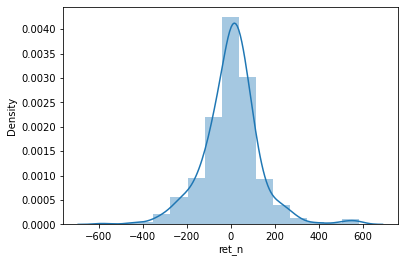

In [48]:
print("Media de retornos: ", df_[df_["ppvi"] == 1]["ret_n"].mean())
print("STD de retornos: ", df_[df_["ppvi"] == 1]["ret_n"].std())
sns.distplot(df_[df_["ppvi"] == 1]["ret_n"], bins=15)

### Verificando pontos operacionais encontrados

In [38]:
def plot_candle_and_extremes(df_):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, specs=[[{"secondary_y": False}], [{"secondary_y": True}]],
                        vertical_spacing=0.03, subplot_titles=('OHLC', 'Volume'), row_width=[0.2, 0.7])

    fig.add_trace(go.Candlestick(x=df_.index, open=df_['open'], high=df_['high'], low=df_['low'], close=df_['close']), row=1, col=1)
    
    fig.add_trace(go.Bar(x=df_.index, y=df_['real_volume'], showlegend=False, opacity=1), row=2, col=1, secondary_y=True)
    fig.add_trace(go.Scatter(x=df_.index, y=df_['roll_vol'], showlegend=False, opacity=1, marker_color="red"), row=2, col=1)
    fig.add_trace(go.Scatter(x=df_.index, y=df_['roll_vol_mean'], showlegend=False, opacity=1), row=2, col=1)
    # fig.add_trace(go.Scatter(x=df_.index, y=df_['roll_vol_+'], showlegend=False, opacity=1), row=2, col=1)
    
    fig.add_trace(go.Scatter(x=df_[df_["local_min"] == 1].index, y=df_[df_["local_min"] == 1]["low"], mode="markers", marker_color="cyan", marker_symbol="x", marker_size=15, opacity=0.5), row=1, col=1)
    # fig.add_trace(go.Scatter(x=df_[df_["local_max"] == 1].index, y=df_[df_["local_max"] == 1]["high"], mode="markers", marker_color="red", marker_size=15, opacity=0.5), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_[df_["v_pattern"] == 1].index, y=df_[df_["v_pattern"] == 1]["low"], mode="markers", marker_color="red", marker_size=15, opacity=0.5), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_[df_["ppvi"] == 1].index, y=df_[df_["ppvi"] == 1]["close"], mode="markers", marker_color="yellow", marker_size=15, opacity=0.5), row=1, col=1)

    fig.update_layout(template="plotly_dark", xaxis_rangeslider_visible=False, height=700)
    fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"]), dict(bounds=[18, 9], pattern="hour")])
    fig.show()

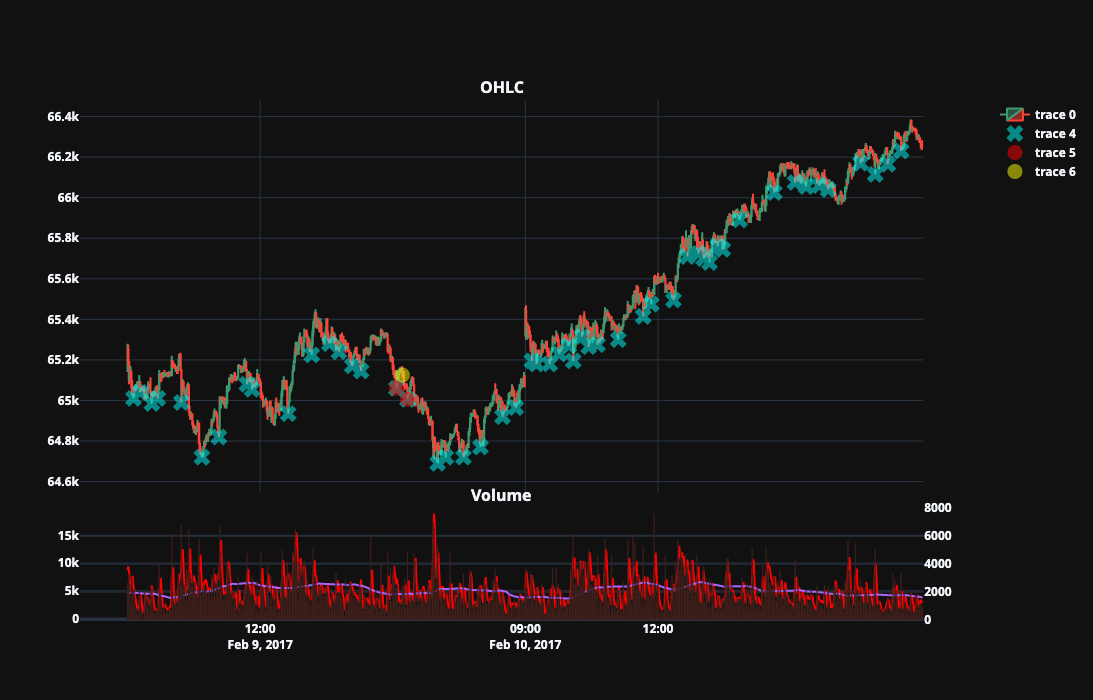

In [46]:
n = 52

index_ppvi = df_[df_["ppvi"] == 1].index.date
dt1 = index_ppvi[n]
dt2 = dt1 + datetime.timedelta(days=2)
df_2 = df_[(df_.index.date >= dt1) & (df_.index.date <= dt2)].copy()

plot_candle_and_extremes(df_2)